In [44]:
import tensorflow as tf
#https://medium.com/%E8%BB%9F%E9%AB%94%E4%B9%8B%E5%BF%83/%E9%81%A9%E5%90%88%E5%A4%A7%E9%87%8F%E8%B3%87%E6%96%99i-o%E7%9A%84%E5%84%B2%E5%AD%98%E6%A0%BC%E5%BC%8F-tfrecord%E7%B0%A1%E4%BB%8B%E8%88%87%E6%93%8D%E4%BD%9C%E6%95%99%E5%AD%B8-cd27e50d51ee

# mnist one example consists of 28*28 byte + 1 byte
# if _bytes_feature's args is alreaddy a list, no need to use []
def _image_feature(value):
    """"Returns a uint8(byte)_list from a byte."""
    if isinstance(value, type(tf.constant(0))):
        # BytesList won't unpack a string from an EagerTensor.
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _label_feature(value):
    """Returns a uint8(byte)_list from a byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [46]:
""" transfer dataset to tfrecord method"""
# the whole image is a byte feature, not a byte list
import os
import struct                                                                   
import numpy as np                                                              
import matplotlib.pyplot as plt                                                 
from PIL import Image
def serialize_example(_label, _image):
    feature = {
        "label": _label_feature(_label),
        "image": _image_feature(_image),
        }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString() 

images_file_name = './train-images.idx3-ubyte'
labels_file_name = './train-labels.idx1-ubyte'
images_dir = './mnist jpeg/'
mnist_images=open(images_file_name,'rb')
mnist_labels=open(labels_file_name,'rb')
# skip header file
_=mnist_images.read(16)
_=mnist_labels.read(8)

# data
# build offset_table while writing TFRecords, int64 for offset of each instance, e.g. offset of instance #100 is 100*8B=800B
# byte is little endian
offset_table=open("mnist-sparse-offset_table",'wb') 
with tf.io.TFRecordWriter("mnist_sparse.tfrecords") as writer:
    for i in range (60000):
        with open(images_dir+str(i)+'.jpg','rb') as f:
            buf=mnist_labels.read(1)
            _label=buf
            img_bytes=f.read()            
                
            current_filesize=os.path.getsize("mnist_sparse.tfrecords")
            if(i%4000==0):
                print(i,end=' ')
                print("offset=",current_filesize)
                
            offset_table.write(current_filesize.to_bytes(8, byteorder = 'little'))
            
            serialized_example = serialize_example(_label, img_bytes)
            writer.write(serialized_example)

0 offset= 0
4000 offset= 2457808
8000 offset= 4913529
12000 offset= 7370026
16000 offset= 9835680
20000 offset= 12292118
24000 offset= 14758044
28000 offset= 17211337
32000 offset= 19665418
36000 offset= 22123890
40000 offset= 24585380
44000 offset= 27039937
48000 offset= 29503891
52000 offset= 31965363
56000 offset= 34421808


label= b'\x05'


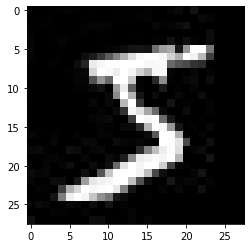

label= b'\x00'


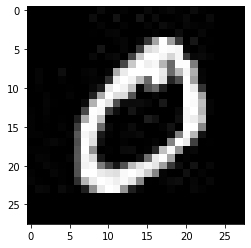

In [50]:
""" standard way to iterate tfr, to make sure the tfr format is right """

dataset = tf.data.TFRecordDataset('mnist_sparse.tfrecords')

image_feature_description = {
    'label': tf.io.FixedLenFeature([], tf.string),
    # var len is different
    'image': tf.io.FixedLenFeature([],tf.string),
}

def _parse_function(example_proto):
    serialized_example = tf.io.parse_single_example(example_proto, image_feature_description)
    return serialized_example


for idx, features in enumerate(dataset):
    parsed_features = _parse_function(features)
    print("label=",parsed_features['label'].numpy())    
    image=tf.io.decode_jpeg(parsed_features['image'])
    plt.imshow(np.asarray(image).reshape((28,28)),cmap = plt.cm.gray)                                        
    plt.show()
    
    if idx>=1:
        break

In [52]:
"""offset table read test"""

oft=open("mnist-sparse-offset_table",'rb')
idx=5
for i in range (60000):
    
    tmp=oft.read(8)
    #print(tmp)
    if(i%4000==0):
        length=struct.unpack("<Q",tmp)
        print(length[0])

0
2457808
4913529
7370026
9835680
12292118
14758044
17211337
19665418
22123890
24585380
27039937
29503891
31965363
34421808


In [53]:
""" the actual read() function """

def sparse_random_read(binfile, oft, idx):
    # read offset, 8B per instance
    #TODO: oft should be loaded to mem
    oft.seek(idx*8,0)
    tmp=oft.read(8)
    offset=struct.unpack("<Q",tmp)[0]
    print("offset=",offset)
    
    # read data length
    binfile.seek(offset,0)
    tmp=binfile.read(8)
    length=struct.unpack("<Q",tmp)[0]
    print("length=",length)
    # we already read first 8B
    record_l_from_col2=length+8
    
    # random read
    tmp=binfile.read(record_l_from_col2)
    r_data=tmp[4:-4]

    # deserialize data
    parsed_features = _parse_function(r_data)
    return parsed_features
    
    

In [55]:
""" test read() function """

binfile=open('mnist_sparse.tfrecords','rb')
oftfile=open('mnist-sparse-offset_table','rb')
a=sparse_random_read(binfile,oftfile, 20)

print(a)

offset= 12119
length= 612
{'image': <tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xc0\x00\x0b\x08\x00\x1c\x00\x1c\x01\x01\x11\x00\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xd2\xd3\xd4\xd5\xd6\xd7\xd8\xd9\xda\xe1\xe2\xe3\xe4\xe5